# Alternus - Vera : Stance Detection

Author: Vidhi Shah
***
The idea of fake news is often referred to as click-bait in social trends and is defined as a “made up story with an intention to deceive, geared towards getting clicks”. Some news articles have titles which grab a reader’s interest. Yet, the author only emphasizes a specific part of the article in the title. If the article itself does not focus on or give much truth to what the title had written, the news may be misleading.

The goal of this project is to use natural language processing techniques to automate stance detection, since it is not practical for humans to fact check every piece of information produced by the media.

Stance detection is a method used to determine the quality of a news article by taking into consideration what other organisations write about the same headline. A body of text is claimed to agree, disagree, discuss, or be unrelated to a headline, Fake News Challenge (2016) Stance detection is the method that will be used to determine the quality of a news source. 

From the [FakeChallenge.org](http://fakenewschallenge.org) a dataset hase been provided which consists of a headline and a body of text. This body of text may be from a different article. Allowing bodies of text from different articles allows this system to take into account what the other organisations are saying about he same headline. The output of the system will be the stance of the body of text related to the title. The system will support will support the following stance types:
- Agrees
- Disagrees
- Discusses
- Unrelated

With this system, for a set of news headlines, statistics can be gathered with respect to the stances. With these statistics, a user can come to their own conclusion of whether a new organisation has reputable news sources. To achieve these stances, this system will train on the data supplied by the fake news challenge. This data will provide the stance along with the headline and body to allow the system to learn which word combinations lead to which stance. For testing, data will be provided without the stances.

This project was inspired by the Fake News Challenge (FNC)
[FakeChallenge.org](http://fakenewschallenge.org) <br />


In [1]:
# ! pip install langdetect

In [2]:
from os import path
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import pylab as py
from scipy.sparse import hstack
from scipy.sparse import coo_matrix
from tqdm import tqdm
from scipy import sparse
import csv, random, numpy, os, re, nltk, scipy, gensim
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from langdetect import detect
from sklearn.ensemble import RandomForestClassifier
from csv import DictReader
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
# import score

In [3]:
class DataSet():
    def __init__(self, path="data"):
        self.path = path

        print("Reading dataset")
        bodies = "train_bodies.csv"
        stances = "train_stances.csv"

        self.stances = self.read(stances)
        articles = self.read(bodies)
        self.articles = dict()

        #make the body ID an integer value
        for s in self.stances:
            s['Body ID'] = int(s['Body ID'])

        #copy all bodies into a dictionary
        for article in articles:
            self.articles[int(article['Body ID'])] = article['articleBody']

        print("Total stances: " + str(len(self.stances)))
        print("Total bodies: " + str(len(self.articles)))



    def read(self,filename):
        rows = []
        with open(self.path + "/" + filename, "r", encoding='utf-8') as table:
            r = DictReader(table)

            for line in r:
                rows.append(line)
        return rows


In [4]:
dataset = DataSet()

Reading dataset
Total stances: 49972
Total bodies: 1683


In [5]:
dataset.stances[0]

OrderedDict([('Headline',
              "Police find mass graves with at least '15 bodies' near Mexico town where 43 students disappeared after police clash"),
             ('Body ID', 712),
             ('Stance', 'unrelated')])

In [6]:
dataset.articles[712]

'Danny Boyle is directing the untitled film\n\nSeth Rogen is being eyed to play Apple co-founder Steve Wozniak in Sony’s Steve Jobs biopic.\n\nDanny Boyle is directing the untitled film, based on Walter Isaacson\'s book and adapted by Aaron Sorkin, which is one of the most anticipated biopics in recent years.\n\nNegotiations have not yet begun, and it’s not even clear if Rogen has an official offer, but the producers — Scott Rudin, Guymon Casady and Mark Gordon — have set their sights on the talent and are in talks.\n\nOf course, this may all be for naught as Christian Bale, the actor who is to play Jobs, is still in the midst of closing his deal. Sources say that dealmaking process is in a sensitive stage.\n\nInsiders say Boyle will is flying to Los Angeles to meet with actress to play one of the female leads, an assistant to Jobs. Insiders say that Jessica Chastain is one of the actresses on the meeting list.\n\nWozniak, known as "Woz," co-founded Apple with Jobs and Ronald Wayne. He

In [7]:
def read_ids(file,base):
    ids = []
    with open(base+"/"+file,"r") as f:
        for line in f:
            ids.append(int(line))
        return ids
    
def split(dataset, base="splits"):
    if not (os.path.exists(base+"/"+"training_ids.txt")
            and os.path.exists(base+"/"+"dev_ids.txt") and os.path.exists(base+"/"+"test_ids.txt")):
        raise Exception("There is an error and the dataset reader cannot find the "
                        "{training_ids|test_ids|dev_ids}.txt file. Please make sure your python paths "
                        "are configured correctly")

    training_ids = read_ids("training_ids.txt",base)
    dev_ids = read_ids("dev_ids.txt",base)
    test_ids = read_ids("test_ids.txt",base)

    #return the stances that meet these criteria
    training_stances = []
    dev_stances = []
    test_stances = []

    for stance in dataset.stances:
        if stance['Body ID'] in training_ids:
            training_stances.append(stance)
        elif stance['Body ID'] in dev_ids:
            dev_stances.append(stance)
        elif stance['Body ID'] in test_ids:
            test_stances.append(stance)


    return {"training":training_stances, "dev":dev_stances, "test": test_stances}

In [8]:
print("\n[1] Loading data..")
data_splits = split(dataset)
# in the format: Stance, Headline, BodyID
training_data = data_splits['training']
dev_data = data_splits['dev']
test_data = data_splits['test'] # currently 0 test points

# Change the number of training examples used.
N = int(len(training_data) * 1.0)
training_data = training_data[:N]

print("\t-Training size:\t", len(training_data))
print("\t-Dev size:\t", len(dev_data))
print("\t-Test data:\t", len(test_data))


[1] Loading data..
	-Training size:	 40106
	-Dev size:	 4835
	-Test data:	 5031


In [9]:
len(dataset.articles)

1683

In [10]:
# Get the bodies of training data points
def get_bodies(data):
    bodies = []
    for i in range(len(data)):
        bodies.append(dataset.articles[data[i]['Body ID']])
    return bodies

In [11]:
# Get the headlines of training data points
def get_headlines(data):
    headlines = []
    for i in range(len(data)):
        headlines.append(data[i]['Headline'])
    return headlines

In [12]:
# Get bodies and headlines for dev and training data
training_bodies = get_bodies(training_data)
training_headlines = get_headlines(training_data)
dev_bodies = get_bodies(dev_data)
dev_headlines = get_headlines(dev_data)
test_bodies = get_bodies(test_data)
test_headlines = get_headlines(test_data)

print(len(training_bodies))
print(len(training_headlines))
print(len(dev_bodies))
print(len(dev_headlines))
print(len(test_bodies))
print(len(test_headlines))

40106
40106
4835
4835
5031
5031


In [13]:
# Function for extracting tf-idf vectors (for both the bodies and the headlines).
# https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments

def extract_tfidf(training_headlines, training_bodies, dev_headlines="", dev_bodies="", test_headlines="", test_bodies=""):
    # Body vectorisation
    body_vectorizer = TfidfVectorizer(ngram_range=(1, 2), lowercase=True, stop_words='english')#, max_features=1024)
    bodies_tfidf = body_vectorizer.fit_transform(training_bodies)

    # Headline vectorisation
    headline_vectorizer = TfidfVectorizer(ngram_range=(1, 2), lowercase=True, stop_words='english')#, max_features=1024)
    headlines_tfidf = headline_vectorizer.fit_transform(training_headlines)

    # Tranform dev/test bodies and headlines using the trained vectorizer (trained on training data)
    bodies_tfidf_dev = body_vectorizer.transform(dev_bodies)
    headlines_tfidf_dev = headline_vectorizer.transform(dev_headlines)

    bodies_tfidf_test = body_vectorizer.transform(test_bodies)
    headlines_tfidf_test = headline_vectorizer.transform(test_headlines)
    
    feature_names = np.array(body_vectorizer.get_feature_names())
    sorted_by_idf = np.argsort(body_vectorizer.idf_) 
    print('Features with lowest and highest idf in the body vector:\n')
    # The token which appears maximum times but it is also in all documents, has its idf the lowest
    print("Features with lowest idf:\n{}".format(
    feature_names[sorted_by_idf[:10]]))
    # The tokens can have the most idf weight because they are the only tokens that appear in one document only
    print("\nFeatures with highest idf:\n{}".format(
    feature_names[sorted_by_idf[-10:]]))

    # Combine body_tfdif with headline_tfidf for every data point. 
    training_tfidf = scipy.sparse.hstack([bodies_tfidf, headlines_tfidf])
    dev_tfidf = scipy.sparse.hstack([bodies_tfidf_dev, headlines_tfidf_dev])
    test_tfidf = scipy.sparse.hstack([bodies_tfidf_test, headlines_tfidf_test])

    return training_tfidf, dev_tfidf, test_tfidf

In [14]:
lemmatizer = nltk.WordNetLemmatizer()

# Tokenisation, Normalisation, Capitalisation, Non-alphanumeric removal, Stemming-Lemmatization
def preprocess(string):
    # to lowercase, non-alphanumeric removal
    step1 = " ".join(re.findall(r'\w+', string, flags=re.UNICODE)).lower()
    step2 = [lemmatizer.lemmatize(t).lower() for t in nltk.word_tokenize(step1)]

    return step2

# Function for extracting word overlap
def extract_word_overlap(headlines, bodies):
    word_overlap = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        preprocess_headline = preprocess(headline)
        preprocess_body = preprocess(body)
        
        # Lenght of common words b/w body and headline / Length of all the words of body & headline
        features = len(set(preprocess_headline).intersection(preprocess_body)) / float(len(set(preprocess_headline).union(preprocess_body)))
        word_overlap.append(features)
        
        # Convert the list to a sparse matrix (in order to concatenate the cos sim with other features)
        word_overlap_sparse = scipy.sparse.coo_matrix(numpy.array(word_overlap)) 
    return word_overlap_sparse

In [15]:
# Function for extracting the cosine similarity between bodies and headlines. 
def extract_cosine_similarity(headlines, bodies):
    vectorizer = TfidfVectorizer(ngram_range=(1,2), lowercase=True, stop_words='english')#, max_features=1024)
    
    cos_sim_features = []
    for i in range(0, len(bodies)):
        body_vs_headline = []
        body_vs_headline.append(bodies[i])
        body_vs_headline.append(headlines[i])
        tfidf = vectorizer.fit_transform(body_vs_headline)
        
        cosine_similarity = (tfidf * tfidf.T).A
        cos_sim_features.append(cosine_similarity[0][1])

    # Convert the list to a sparse matrix (in order to concatenate the cos sim with other features)
    cos_sim_array = scipy.sparse.coo_matrix(numpy.array(cos_sim_features)) 

    return cos_sim_array

In [16]:
# Function for combining features of various types (lists, coo_matrix, np.array etc.)
def combine_features(tfidf_vectors, cosine_similarity, word_overlap):
    combined_features =  sparse.bmat([[tfidf_vectors, word_overlap.T, cosine_similarity.T]])
    return combined_features

In [17]:
# Function for extracting features
# Feautres: 1) Word Overlap, 2) TF-IDF vectors, 3) Cosine similarity, 4) Word embeddings
def extract_features(train, dev, test):
# Get bodies and headlines for dev and training data
    training_bodies = get_bodies(training_data)
    training_headlines = get_headlines(training_data)
    dev_bodies = get_bodies(dev_data)
    dev_headlines = get_headlines(dev_data)
    test_bodies = get_bodies(test_data)
    test_headlines = get_headlines(test_data)

    # Extract tfidf vectors
    print("\t-Extracting tfidf vectors..")
    training_tfidf, dev_tfidf, test_tfidf = extract_tfidf(training_headlines, training_bodies, dev_headlines, dev_bodies, test_headlines, test_bodies)
    print("\t-Tfidf vectors extracted..")

    # Extract word overlap 
    print("\t-Extracting word overlap..")
    training_overlap = extract_word_overlap(training_headlines, training_bodies)
    dev_overlap = extract_word_overlap(dev_headlines, dev_bodies)
    test_overlap = extract_word_overlap(test_headlines, test_bodies)
    print("\t-Word overlap extracted..")

#     # Extract cosine similarity between bodies and headlines. 
    print("\t-Extracting cosine similarity..")
    training_cos = extract_cosine_similarity(training_headlines, training_bodies)
    dev_cos = extract_cosine_similarity(dev_headlines, dev_bodies)
    test_cos = extract_cosine_similarity(test_headlines, test_bodies)
    print("\t-Cosine similarity extracted..")

    # Combine the features
    training_features = combine_features(training_tfidf, training_cos, training_overlap)
    dev_features = combine_features(dev_tfidf, dev_cos, dev_overlap)
    test_features = combine_features(test_tfidf, test_cos, test_overlap)
    print("\t-Combined features returned..")

    return training_features, dev_features, test_features

In [18]:
test_data

[OrderedDict([('Headline',
               'Vandals add rude paint job to $2.5m Bugatti (but luckily for the owner it all turned out to be a hoax)'),
              ('Body ID', 615),
              ('Stance', 'unrelated')]),
 OrderedDict([('Headline',
               'No, Robert Plant Didn’t Rip Up an $800 Million Contract'),
              ('Body ID', 295),
              ('Stance', 'agree')]),
 OrderedDict([('Headline', 'N. Korea’s Kim has leg injury but in control'),
              ('Body ID', 570),
              ('Stance', 'unrelated')]),
 OrderedDict([('Headline',
               'Who Is Michael Zehaf-Bibeau? Ottawa Shooter Suspect Identified By Canadian Officials '),
              ('Body ID', 1251),
              ('Stance', 'unrelated')]),
 OrderedDict([('Headline',
               "Taylor Lianne Chandler: Michael Phelps' Cougar Girlfriend Revealed?"),
              ('Body ID', 1337),
              ('Stance', 'unrelated')]),
 OrderedDict([('Headline',
               'Catholic Priest Dead 

In [19]:
# Feature extraction
print("[2] Extracting features.. ")
# extract_features(training_data, dev_data, test_data)
training_features, dev_features, test_features = extract_features(training_data, dev_data, test_data)

[2] Extracting features.. 
	-Extracting tfidf vectors..
Features with lowest and highest idf in the body vector:

Features with lowest idf:
['said' 'told' 'people' 'according' 'year' 'time' 'news' 'just' 'new'
 'reports']

Features with highest idf:
['real problem' 'point videos' 'real renderings' 'screens used'
 'authenticity document' 'having salespeople' 'having surgery'
 'maintained price' 'authenticity looking' 'summaries']


0it [00:00, ?it/s]

	-Tfidf vectors extracted..
	-Extracting word overlap..


40106it [04:15, 156.68it/s]
4835it [00:19, 246.71it/s]
5031it [00:19, 263.34it/s]


	-Word overlap extracted..
	-Extracting cosine similarity..
	-Cosine similarity extracted..
	-Combined features returned..


In [21]:
classes = ['agree', 'disagree', 'discuss', 'unrelated']

def report_score(test,pred,algo):
    #accuracy calculation
    accuracy = accuracy_score(test,pred)
    print('\n Accuracy_score for %s = %s \n'%(algo,accuracy))
    
    #confusion_matrix
    mat = confusion_matrix(test,pred)
    fig, ax = plt.subplots(figsize=(11,11))  
    ax.set_title("Confusion Matrix for %s" %algo)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,cmap="icefire",
                xticklabels=classes,yticklabels=classes,linewidths=.3, ax=ax)
    plt.xlabel('True label')
    plt.ylabel('Predicted label');

    #classification report
    cls = classification_report(test,pred, target_names=classes)
    print(cls)

In [22]:
# Creating targets
targets_tr = [a['Stance'] for a in training_data]
targets_dev = [a['Stance'] for a in dev_data]
targets_test = [a['Stance'] for a in test_data]

In [23]:
def change(f):
    if f == 'unrelated':
        return 0
    elif f == 'disagree':
        return 1
    elif f == 'discuss':
        return 2
    elif f == 'agree':
        return 3
    else:
        return 0

y = [change(x) for x in targets_tr]
y_test = [change(x) for x in targets_test]

In [24]:
def predict(self, text):
        predicted = self.logR_pipeline.predict([text])
        predicedProb = self.logR_pipeline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)

In [25]:
test_features

<5031x204365 sparse matrix of type '<class 'numpy.float64'>'
	with 1171073 stored elements in COOrdinate format>

[3] Fitting model..
	-Logistic Regression
[4] Evaluating model..

 Accuracy_score for Logistic Regression = 0.8988272709202941 

             precision    recall  f1-score   support

      agree       0.48      0.49      0.48       324
   disagree       0.32      0.38      0.35        89
    discuss       0.80      0.83      0.82       997
  unrelated       0.98      0.97      0.97      3621

avg / total       0.90      0.90      0.90      5031

	-Done with Logistic Regression


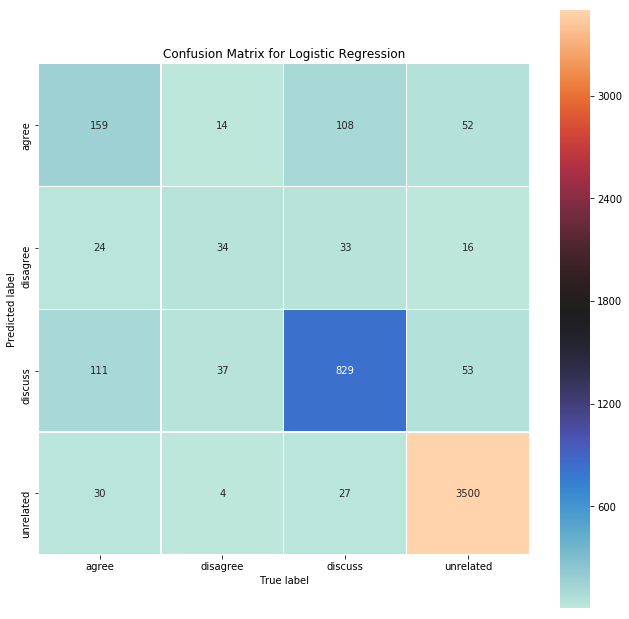

In [26]:
# Fitting model
print("[3] Fitting model..")
print("\t-Logistic Regression")
lr = LogisticRegression(C = 1.0, class_weight='balanced', solver="lbfgs", max_iter=150) 
y_pred_lr = lr.fit(training_features, targets_tr).predict(test_features)
# Evaluation
print("[4] Evaluating model..")
report_score(targets_test, y_pred_lr,'Logistic Regression')
print("\t-Done with Logistic Regression")

[3] Fitting model..
	-Random Forest Classifier
[4] Evaluating model..

 Accuracy_score for Random Forest Classifier = 0.8054064798250845 

             precision    recall  f1-score   support

      agree       0.27      0.37      0.31       324
   disagree       0.66      0.21      0.32        89
    discuss       0.62      0.80      0.70       997
  unrelated       0.95      0.86      0.90      3621

avg / total       0.84      0.81      0.81      5031

	-Done with Random Forest Classifier


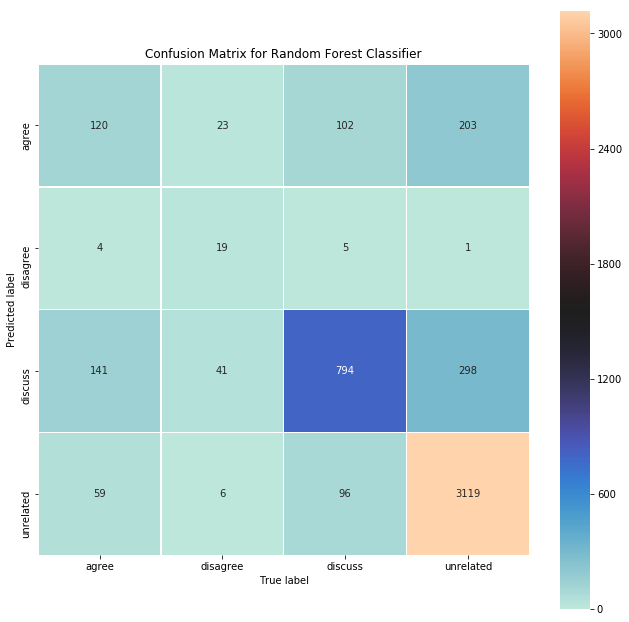

In [27]:
print("[3] Fitting model..")
print("\t-Random Forest Classifier")
rf = RandomForestClassifier(n_estimators=10, random_state=12345)
y_pred_rf = rf.fit(training_features, targets_tr).predict(test_features)
# Evaluation
print("[4] Evaluating model..")
report_score(targets_test, y_pred_rf,'Random Forest Classifier')
print("\t-Done with Random Forest Classifier")

[3] Fitting model..
	-Multinomial Naive Bayes
[4] Evaluating model..

 Accuracy_score for Multinomial Naive Bayes = 0.4370900417412045 

             precision    recall  f1-score   support

      agree       0.13      0.43      0.20       324
   disagree       0.10      0.45      0.17        89
    discuss       0.34      0.71      0.46       997
  unrelated       0.88      0.36      0.51      3621

avg / total       0.71      0.44      0.48      5031

	-Done with Multinomial Naive Bayes


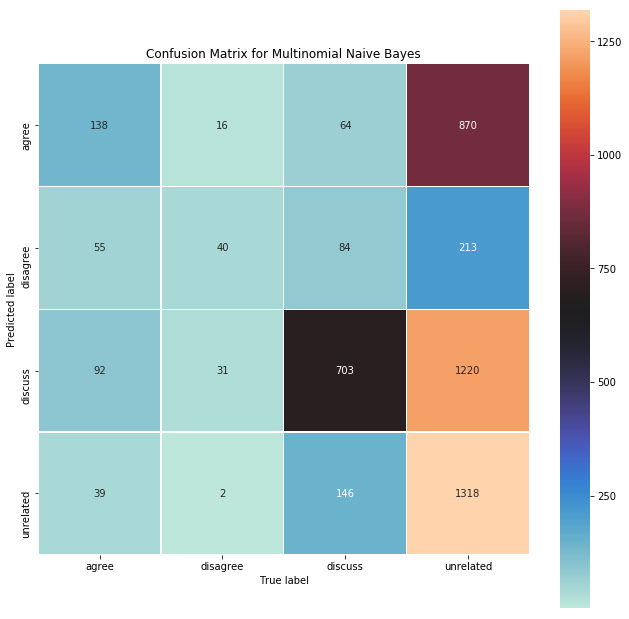

In [28]:
print("[3] Fitting model..")
print("\t-Multinomial Naive Bayes")
nb = MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
y_pred_nb = nb.fit(training_features, targets_tr).predict(test_features)
# Evaluation
print("[4] Evaluating model..")
report_score(targets_test, y_pred_nb,'Multinomial Naive Bayes')
print("\t-Done with Multinomial Naive Bayes")

[3] Fitting model..
	-XGBoost Classifier


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[4] Evaluating model..

 Accuracy_score for XGBoost = 0.4370900417412045 

             precision    recall  f1-score   support

      agree       0.13      0.43      0.20       324
   disagree       0.10      0.45      0.17        89
    discuss       0.34      0.71      0.46       997
  unrelated       0.88      0.36      0.51      3621

avg / total       0.71      0.44      0.48      5031

	-Done with XGBoost Classifier


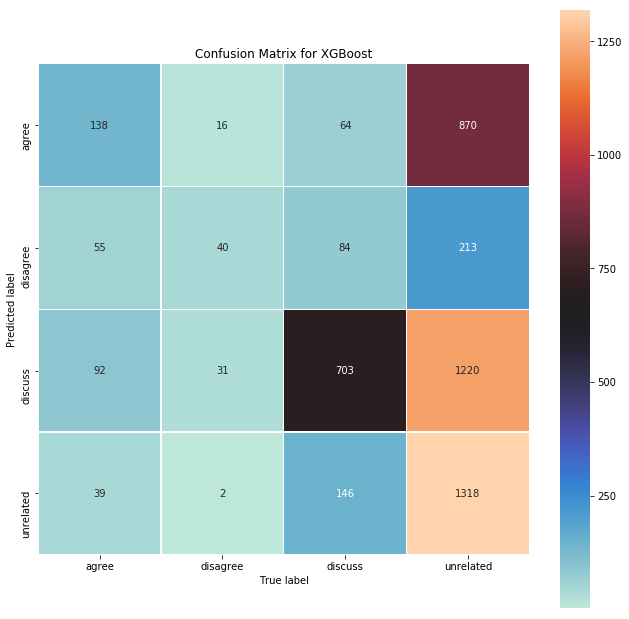

In [29]:
print("[3] Fitting model..")
print("\t-XGBoost Classifier")
xgb = XGBClassifier()
y_pred_xgb = xgb.fit(training_features, targets_tr).predict(test_features)
# Evaluation
print("[4] Evaluating model..")
report_score(targets_test, y_pred_nb,'XGBoost')
print("\t-Done with XGBoost Classifier")

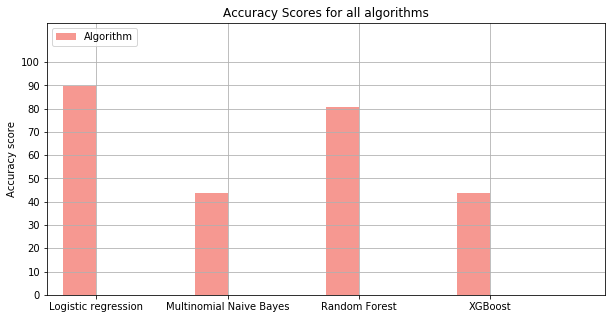

In [38]:
width = 0.25


# IMPROVED_SYSTEM: Logistic, MNV, RF
score = [89.88, 43.71, 80.54, 43.70]

# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

pos = list(range(len(score)))

plt.bar(pos, score, width, alpha=0.5, color='#EE3224', label='Development set')

# Set the y axis label
ax.set_ylabel('Accuracy score')

# Set the chart's title
ax.set_title('Accuracy Scores for all algorithms')

# Set the position of the x ticks
ax.set_xticks([p + 0.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(['Logistic regression', 'Multinomial Naive Bayes', 'Random Forest', 'XGBoost'])
ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])


plt.legend(['Algorithm'], loc='upper left')


plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(score)*1.3])

plt.grid()
plt.show()

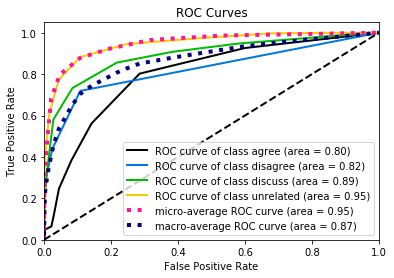

In [46]:
# ! pip install scikit-plot
import scikitplot as skplt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# y_true = classes# ground truth labels
y_probas = rf.predict_proba(test_features)# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(targets_test, y_probas)
plt.show()